In [2]:
library(jsonlite)
library(ggplot2)
library(ggmap)
library(scatterplot3d)
library(dbscan)
library(sp)

Warning message:
“package ‘jsonlite’ was built under R version 3.3.3”

In [3]:
setwd("/home/hduser1/Yelp")

biz_food = stream_in(file("biz_food.json"))
biz_food = biz_food[which(!is.na(biz_food$longitude) & biz_food$state != "IL"),]
byState = split(biz_food, f=biz_food$state)

states = unique(biz_food$state)

opening file input connection.


 Imported 60702 records. Simplifying...


closing file input connection.


In [4]:
# generate maps for each state
maps = lapply(states, function(x){
  df = byState[[x]]
  return(get_map(location = c(median(df$longitude), median(df$latitude)), maptype = "roadmap", zoom = 11))
})

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=33.48049,-111.97732&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35.21977,-80.84003&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=36.11789,-115.17198&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=41.45816,-81.68406&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=43.671055,-79.402815&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=40.44109,-79.98223&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false
Map from URL : http://maps.googleapi

In [5]:
# generate density contour plots for each state
density_data = lapply(states, function(x){
  df = byState[[x]]
  i = which(states == x)
  plot = ggmap(maps[[i]]) + geom_density2d(data = df, aes(x = longitude, y = latitude), stat = "density2d")
  return(ggplot_build(plot))
})

Warning message:
“Removed 4063 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 956 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 186 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 2309 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 4090 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 607 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 463 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 79 rows containing non-finite values (stat_density2d).”

In [6]:
rotations = 12
angles = pi/rotations*c(0:(rotations-1))

In [7]:
cluster_outlines = lapply(states, function(st){
  
  i = which(states == st)
  rotated_boundary = lapply(angles, function(angle){
    
    # find outline of density contour plot from specified angle
    df = density_data[[i]]$data[[4]]
    df$x_rot = cos(angle)*df$x + sin(angle)*df$y
    df = df[which(!duplicated(df$x_rot)),]
    levels = unique(df$level)
    ext_points = lapply(levels, function(y){
      df2 = df[which(df$level == y),]
      db = dbscan(df2[,c("x_rot","level")], eps=0.015, minPts=1)
      df2$cluster = db$cluster
      clusters = unique(db$cluster)
      ext_points2 = lapply(clusters, function(z){
        df3 = df2[which(df2$cluster == z),]
        return(df3[which(df3$x_rot == min(df3$x_rot) | df3$x_rot == max(df3$x_rot)),])
      })
      return(do.call("rbind", ext_points2))
    })
    output = do.call("rbind", ext_points)
    output = output[order(output$x_rot),]
    
    # identify maxima, inflection points of rotated boundary
    output = output[,c("x_rot","x","y","level")]
    output$xdiff = c(diff(output$x_rot), 0)
    output$ydiff = c(diff(output$level), 0)
    output$slope = output$ydiff / output$xdiff
    output$slopediff = c(diff(output$slope), 0)
    maxima = output$x_rot[which(output$slope == 0 & output$slopediff < 0)]
    critical_pts = lapply(maxima, function(x_max){
      left = output[which(output$slopediff > 0 & (output$x_rot - x_max) < 0),]
      left = left[order(abs(left$x_rot - x_max)),]
      left = left$x_rot[1] + left$xdiff[1]
      right = output[which(output$slopediff > 0 & (output$x_rot - x_max) > 0),]
      right = right[order(abs(right$x_rot - x_max)),]
      right = right$x_rot[1] + right$xdiff[1]
      i = which(maxima == x_max)
      return(c(i, left, x_max ,right))
    })
    output$left = rep(0, nrow(output))
    output$peak = rep(0, nrow(output))
    output$right = rep(0, nrow(output))
    
    for (j in 1:length(maxima)){
      output$left[which(output$x_rot == critical_pts[[j]][2])] = j
      output$peak[which(output$x_rot == critical_pts[[j]][3])] = j
      output$right[which(output$x_rot == critical_pts[[j]][4])] = j
    }
    output$angle = rep(angle, nrow(output))
    
    return(output[,c("angle","x_rot","x","y","level","left","peak","right")])
    
  })
  
  critical = do.call("rbind", rotated_boundary)
  critical = critical[which(critical$left>0 | critical$peak>0 | critical$right>0),]
  return(critical)
  
})

In [8]:
max_densities = sapply(states, function(st){
  i = which(states == st)
  df = density_data[[i]]$data[[4]]
  levels = unique(df$level)
  return(max(levels))
})

In [11]:
cluster_threshold = sapply(states, function(st){
  i = which(states == st)
  df = cluster_outlines[[i]]
  outer_pts = df[which(df$left > 0 | df$right > 0),]
  return(median(outer_pts$level))
})
cluster_threshold

AZ  NC  NV  OH  ON  PA  QC  WI 
 20  60  50  40 140 120 300 200

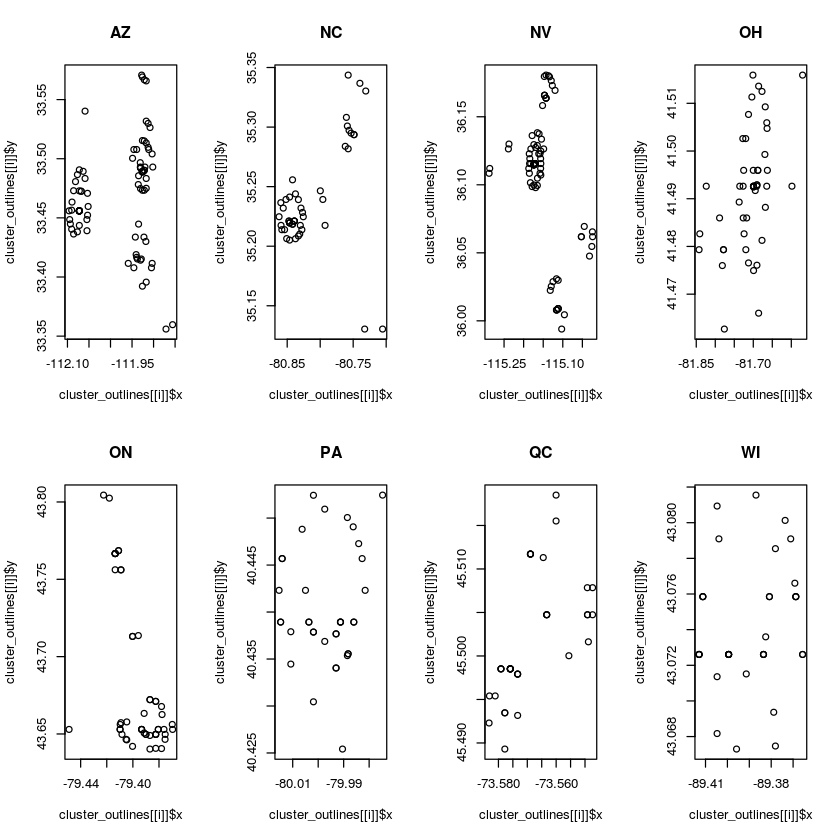

In [12]:
# plot peaks and inflection points surrounding them
par(mfrow=c(2,4))
for (i in 1:8) {
  plot(cluster_outlines[[i]]$x, cluster_outlines[[i]]$y, main=states[i])
}

In [13]:
cluster_shadow = lapply(states, function(st){
  i = which(states == st)
  df = density_data[[i]]$data[[4]]
  df = df[which(df$level >= cluster_threshold[st]),]
  return(df)
})

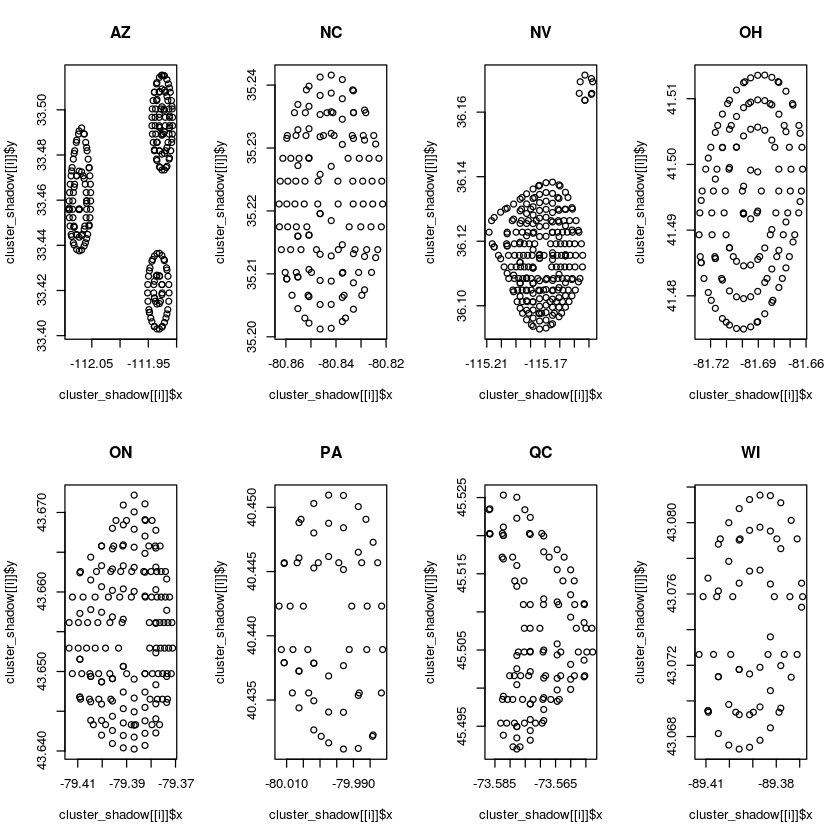

In [14]:
par(mfrow=c(2,4))
for (i in 1:8) {
  plot(cluster_shadow[[i]]$x, cluster_shadow[[i]]$y, main=states[i])
}

In [15]:
cluster_boundary = lapply(states, function(st){
  i = which(states == st)
  df = cluster_shadow[[i]]
  db = dbscan(df[,c("x","y")], eps=0.025, minPts=5)
  df$cluster = db$cluster
  clusters = unique(db$cluster)
  boundaries = lapply(clusters, function(n){
    dfsub = df[which(df$cluster == n),]
    dfsub = dfsub[which(dfsub$level == min(dfsub$level)),]
    return(dfsub)
  })
  return(do.call("rbind", boundaries))
})

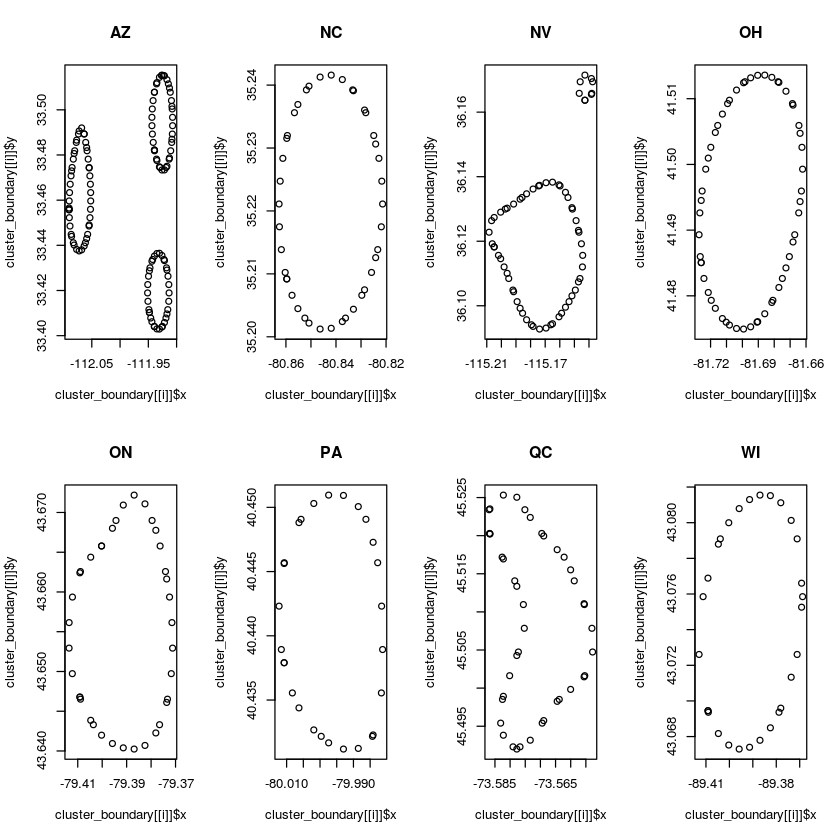

In [16]:
par(mfrow=c(2,4))
for (i in 1:8) {
  plot(cluster_boundary[[i]]$x, cluster_boundary[[i]]$y, main=states[i])
}

In [17]:
biz_in_cluster = lapply(states, function(st){
  i = which(states == st)
  clusters = unique(cluster_boundary[[i]]$cluster)
  biz = byState[[i]]
  biz_ids = lapply(clusters, function(n){
    poly = cluster_boundary[[i]][which(cluster_boundary[[i]]$cluster == n),]
    in_cluster = point.in.polygon(biz$longitude, biz$latitude, poly$x, poly$y)
    ids = biz$business_id[in_cluster > 0]
    return(ids)
  })
  biz_ids = unlist(biz_ids)
  biz = biz[which(biz$business_id %in% biz_ids),]
  return(biz)
})

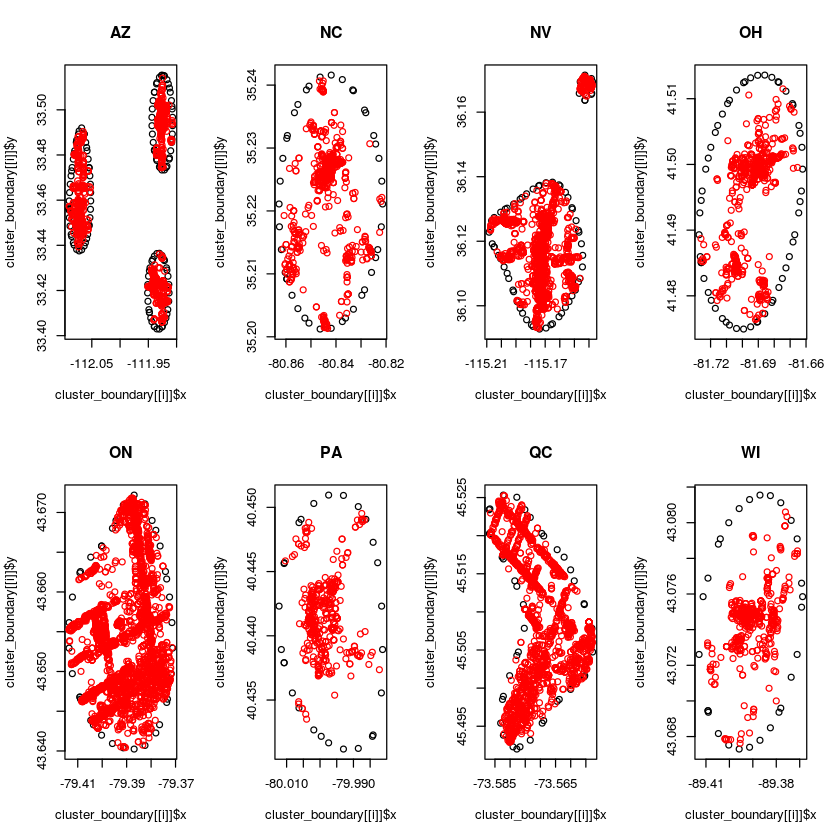

In [18]:
par(mfrow=c(2,4))
for (i in 1:8) {
  plot(cluster_boundary[[i]]$x, cluster_boundary[[i]]$y, main=states[i])
  b = biz_in_cluster[[i]]
  points(b$longitude, b$latitude, col="red")
}

In [19]:
biz_food_clustered = do.call("rbind", biz_in_cluster)